<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Hypothesize and Design Expms

<h3>Answer questions based on known info to form hypotheses</h3>

- Eg) Can a 1L attn only model do this task?
    - Attention is really good at the primitive operations of looking nearby, or copying information. Eg) at `to` it should look for names and predict that those names came next (eg the skip trigram " John...to -> John")
    - But it's much harder to tell how <i>many</i> of each previous name there are - attending 0.3 to each copy of John will look exactly the same as attending 0.6 to a single John token
- Eg) How many heads to do this task then? On which tokens?
    - The natural place to break this symmetry is on the second " John" token - telling whether there is an earlier copy of the <i>current</i> token should be a much easier task.
    - So expect there to be a head which detects duplicate tokens on the second " John" token, and then another head which moves that information from the second " John" token to the " to" token.

<h3>Form Hypotheses</h3>

Possible way to choose a previous token:
1. By MLP: Detect all preceding [token types] and move this information to " [last token]" and then delete any token corresponding to the duplicate token feature (vector). This feels easier done with a non-linearity, since precisely cancelling out vectors is hard, so I'd imagine an MLP layer deletes the " John" direction of the residual stream
    - if it's mostly MLPs  which attend to " Mary" but not to any "John" it's probably hypothesis 1.
2. By attention head: Have a head which attends to all previous token, but where the duplicate token features <i>inhibit</i> it from attending to specific names. So this only attends to Mary. And then the output of this head maps to the logits.  
    - if it's mostly attention heads, it's probably hypothesis 2

<h3>Plan Experiment Ideas To Execute</h3>

- A test that could distinguish these two is to look at which components of the model add directly to the logits: MLPs, or heads? [See which components (head/MLP) x-points increase in Layer Attribution](https://colab.research.google.com/drive/1nLb8rq60wEoT5_QFXFoyI5rWHFbshAwJ#scrollTo=DQyELRKZIAiS&line=2&uniqifier=1)

<b>How to Find Head Functions</b>

Eg) To identify duplicate token heads: find heads which
1. Attend from " John" to " John"
2. Whose outputs are then moved to the " to" token by V-Composition with another head

# Setup
(No need to change anything)

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-v_1ucg73
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-v_1ucg73
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit e98763689463ff0fb928b0f9f48ff9e4d1a3bf01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.2 MB/s eta 0:00:00
   

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

if IN_COLAB or not DEBUG_MODE:
    # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "png"

In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
# import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [ ]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Load Model

Decide which model to use (eg. gpt2-small vs -medium)

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


# Inputs

In [ ]:
names = ["Adam", "Bob", "Claire", "Don", "Eve"]

prompts = ["{} is {}. {} is {}. {} is {}. {} is {}. {} is".format(names[0], i, names[1], i+1, names[2], i+2, names[3], i+3, names[4]) for i in range(1, 18)]
answers = [(str(i+4), str(i+3)) for i in range(1, 18)]
corrupted_prompts = ["{} is {}. {} is {}. {} is {}. {} is {}. {} is".format(names[0], i, names[1], i+1, names[2], i+2, names[3], i+2, names[4]) for i in range(1, 18)]

In [ ]:
answer_tokens = []
for answer in answers:
    correct_token = model.to_single_token(answer[0])
    incorrect_token = model.to_single_token(answer[1])
    answer_tokens.append((correct_token, incorrect_token))
answer_tokens = torch.tensor(answer_tokens).cuda()

# Direct Logit Attribution: Identify Impt Areas

In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)
tokens = tokens.cuda() # Move the tokens to the GPU
original_logits, cache = model.run_with_cache(tokens) # Run the model and cache all activations

def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

print("Per prompt logit difference:", logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True))
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff.item())

Per prompt logit difference: tensor([5.7888, 5.5339, 5.9939, 4.7386, 5.3882, 5.4042, 4.8466, 6.4160, 6.4401,
        5.0742, 5.4986, 4.7835, 5.5562, 4.9040, 4.8955, 4.5595, 5.0587],
       device='cuda:0')
Average logit difference: 5.345902442932129


In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
# print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
# print("Logit difference directions shape:", logit_diff_directions.shape)

In [ ]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
final_residual_stream = cache["resid_post", -1]
# print("Final residual stream shape:", final_residual_stream.shape)
final_token_residual_stream = final_residual_stream[:, -1, :]
# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer = -1, pos_slice=-1)

average_logit_diff = einsum("batch d_model, batch d_model -> ", scaled_final_token_residual_stream, logit_diff_directions)/len(prompts)
print("Calculated average logit diff:", average_logit_diff.item())
print("Original logit difference:",original_average_logit_diff.item())

Calculated average logit diff: 5.428539276123047
Original logit difference: 5.345902442932129


**How to interpret**

X = average logit difference

This represents putting an $e^{X}$ higher probability on the correct answer.

## Logit Lens

In [ ]:
def residual_stack_to_logit_diff(residual_stack: Float[torch.Tensor, "components batch d_model"], cache: ActivationCache) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)
    return einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/len(prompts)

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
line(logit_lens_logit_diffs, x=np.arange(model.cfg.n_layers*2+1)/2, hover_name=labels, title="Logit Difference From Accumulate Residual Stream")

**How to interpret**

Model is able to do task (first notable increase in graph) STARTING on Layer:

Layers with very strong performance (sharp increases):
- L

slightly strong performance:
- L

Layers with weak performance:
- L

---

**Note:** Hover over each data point to see what residual stream position it's from!

<details> <summary>Details on `accumulated_resid`</summary>
**Key:** `n_pre` means the residual stream at the start of layer n, `n_mid` means the residual stream after the attention part of layer n (`n_post` is the same as `n+1_pre` so is not included)

* `layer` is the layer for which we input the residual stream (this is used to identify *which* layer norm scaling factor we want)
* `incl_mid` is whether to include the residual stream in the middle of a layer, ie after attention & before MLP
* `pos_slice` is the subset of the positions used. See `utils.Slice` for details on the syntax.
* return_labels is whether to return the labels for each component returned (useful for plotting)
</details>

## Layer Attribution

**How it works**

(Layer L) - (Layer L-1)

Eg) (Attn layer L) - (MLP Layer L-1)

Eg) (MLP Layer L-1) - (Attn Layer L-1)

In [ ]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

**How to interpret**

If there is an increase (> 0), that layer at the peak matters. Layers with sharp increases:
- L

If attn layer matters, information is moved around. Eg) the correct name from the input is moved up

---
<details> <summary> To do later </summary>

[ B/c finding 'impt layers' is algorithmic, we can turn this into code.]

[But plot is good to see holistic trends, instead of just single impt pts]
</details>

## Head Attribution

**How it works**

<details> <summary>Decomposing attention output into sums of heads</summary>

The standard way to compute the output of an attention layer is by concatenating the mixed values of each head, and multiplying by a big output weight matrix. But as described in [A Mathematical Framework] this is equivalent to splitting the output weight matrix into a per-head output (here `model.blocks[k].attn.W_O`) and adding them up (including an overall bias term for the entire layer)
</details>

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(per_head_logit_diffs, "(layer head_index) -> layer head_index", layer=model.cfg.n_layers, head_index=model.cfg.n_heads)
imshow(per_head_logit_diffs, labels={"x":"Head", "y":"Layer"}, title="Logit Difference From Each Head")

Tried to stack head results when they weren't cached. Computing head results now


**How to interpret**

Heads that contribute a lot positively:
- L H

Are these heads on same layer as impt pos layers found before, such as in the Layer attr plot?

Heads that contribute a lot negatively:
- L H

Eg) These could be negative name movers

### Print top heads (by DLA)

In [ ]:
def get_top_indices(tensor, num_top_values):
    # Flatten the 2D tensor
    flattened_tensor = tensor.view(-1)

    # Get the indices and values of the top elements
    top_indices = torch.topk(flattened_tensor, num_top_values)[1]
    top_values = torch.topk(flattened_tensor, num_top_values)[0]

    # Convert the flattened index back to row and column indices
    rows = top_indices // tensor.size(1)
    cols = top_indices % tensor.size(1)

    for i in range(num_top_values):
        row = rows[i].item()
        col = cols[i].item()
        value = top_values[i].item()
        print(f"Top value {i+1}: Layer={row}, Head={col}, Value={value}")

    # Create a list of tuples with row and column indices
    top_indices_tuple = [(row.item(), col.item()) for row, col in zip(rows, cols)]
    return top_indices_tuple

top_indices = get_top_indices(per_head_logit_diffs, 10)

Top value 1: Layer=9, Head=1, Value=0.6134000420570374
Top value 2: Layer=10, Head=7, Value=0.5750123262405396
Top value 3: Layer=8, Head=8, Value=0.07035614550113678
Top value 4: Layer=6, Head=1, Value=0.06564911454916
Top value 5: Layer=11, Head=10, Value=0.05511047691106796
Top value 6: Layer=8, Head=10, Value=0.04856039956212044
Top value 7: Layer=9, Head=5, Value=0.01732252724468708
Top value 8: Layer=7, Head=9, Value=0.010806665755808353
Top value 9: Layer=4, Head=11, Value=0.006220218725502491
Top value 10: Layer=11, Head=7, Value=0.0059038917534053326


## Attention Analysis

**How it works**

MAIN AIM: Head H moves info from which tokens tgt to which tokens src?

(sounds "flipped" b/c src ATTENDS to tgt, means info from tgt goes to src via head H)

We visualize the top 3 positive and negative heads by direct logit attribution, and show these for the first prompt.

---
<details> <summary>Token position, not content?</summary>

Eg) the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"

Thus, attention patterns only say it's moving information FROM that *residual stream position* corresponding to that input token (whether it's ".", "!", etc doesn't matter). But if not '.', and say 'is', does the content of that last token matter?
</details>

In [ ]:
# !pip install pysvelte

In [ ]:
%%capture
!pip install circuitsvis
import circuitsvis as cv

https://arena-ch1-transformers.streamlit.app/[1.2]_Intro_to_Mech_Interp#exercise-visualise-attention-patterns

In [ ]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: Optional[ActivationCache]=None,
    local_tokens: Optional[torch.Tensor]=None,
    title: str=""):
    # Heads are given as a list of integers or a single integer in [0, n_layers * n_heads)
    if isinstance(heads, int):
        heads = [heads]
    elif isinstance(heads, list) or isinstance(heads, torch.Tensor):
        heads = utils.to_numpy(heads)
    # Cache defaults to the original activation cache
    if local_cache is None:
        local_cache = cache
    # Tokens defaults to the tokenization of the first prompt (including the BOS token)
    if local_tokens is None:
        # The tokens of the first prompt
        local_tokens = tokens[0]

    labels = []
    patterns = []
    batch_index = 0
    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])
        labels.append(f"L{layer}H{head_index}")
    str_tokens = model.to_str_tokens(local_tokens)
    patterns = torch.stack(patterns, dim=-1)

    # display(cv.attention.attention_patterns(tokens=str_tokens, attention=patterns))
    cv.attention.attention_patterns(tokens=str_tokens, attention=patterns)

    # return str_tokens, patterns

    # # Plot the attention patterns
    # attention_vis = pysvelte.AttentionMulti(attention=patterns, tokens=str_tokens, head_labels=labels)
    # display(HTML(f"<h3>{title}</h3>"))
    # attention_vis.show()

In [ ]:
# str_tokens = model.to_str_tokens(text)
# for layer in range(model.cfg.n_layers):
#     attention_pattern = cache["pattern", layer]
#     display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern))

In [ ]:
top_k = 3
top_positive_logit_attr_heads = torch.topk(per_head_logit_diffs.flatten(), k=top_k).indices
visualize_attention_patterns(top_positive_logit_attr_heads, title=f"Top {top_k} Positive Logit Attribution Heads")
top_negative_logit_attr_heads = torch.topk(-per_head_logit_diffs.flatten(), k=top_k).indices
visualize_attention_patterns(top_negative_logit_attr_heads, title=f"Top {top_k} Negative Logit Attribution Heads")

In [ ]:
top_positive_logit_attr_heads

tensor([109, 127, 104], device='cuda:0')

In [ ]:
# str_tokens, patterns =
visualize_attention_patterns(top_positive_logit_attr_heads, title=f"Top {top_k} Positive Logit Attribution Heads")

In [ ]:
patterns.shape

torch.Size([19, 19, 3])

In [ ]:
patterns[:,:,0].shape

torch.Size([19, 19])

In [ ]:
head = top_positive_logit_attr_heads[0].item()
layer = head // model.cfg.n_heads
head_index = head % model.cfg.n_heads
print(layer, head_index)

9 1


In [ ]:
cv.attention.attention_pattern(tokens=str_tokens, attention=patterns[:,:,0])

**How to interpret**:
<!-- <details><summary>Instructions for interpreting attention visualization</summary> -->

- Token dest attends to src means: "token dest copies information from which PREVIOUS tokens src"
- Attn Pat: Which heads from token dest (query row) attend to which token src (key col)?
- Look at the query row to see what prev keys in that row it attends to

- Since we're only looking at the direct effect on the logits, which is affected by the final token, we need only look at the attention patterns from the final token.
- eg) if BOTH pos and neg heads at final token (dest) attends to IO (src), they're copying the info to output.
    - QK says where to move information from, then OV says what values are moved. Copy score ignores QK b/c doesn't care what information is moved to.
<!-- </details> -->



In [ ]:
#this stored attn pats using hooks
batch_index = 0 # use first prompt input as display
# cache["attn", 4][batch_index, 4] == cache["attn", 9][batch_index, 1]

In [ ]:
cache["attn", 4][batch_index, 4].shape

torch.Size([19, 19])

In [ ]:
local_cache = cache
local_tokens = tokens[0]
labels = []
patterns = []
batch_index = 0

layer = 4
head_index = 4
# Get the attention patterns for the head
# Attention patterns have shape [batch, head_index, query_pos, key_pos]
patterns.append(local_cache["attn", layer][batch_index, head_index])
labels.append(f"L{layer}H{head_index}")
str_tokens = model.to_str_tokens(local_tokens)
# patterns = torch.stack(patterns, dim=-1)

len(patterns)

1

In [ ]:
def visualize_attention_patterns(
    # heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    layer,
    head_index,
    local_cache: Optional[ActivationCache]=None,
    local_tokens: Optional[torch.Tensor]=None,
    title: str=""):
    # Cache defaults to the original activation cache
    if local_cache is None:
        local_cache = cache
    # Tokens defaults to the tokenization of the first prompt (including the BOS token)
    if local_tokens is None:
        # The tokens of the first prompt
        local_tokens = tokens[0]
    batch_index = 0

    # Get the attention patterns for the head
    # labels = []
    # patterns = []
    # patterns.append(local_cache["attn", layer][batch_index, head_index])    # Attention patterns have shape [batch, head_index, query_pos, key_pos]
    # labels.append(f"L{layer}H{head_index}")
    # patterns = torch.stack(patterns, dim=-1)

    str_tokens = model.to_str_tokens(local_tokens)
    patterns = local_cache["attn", layer][batch_index, head_index]
    display(cv.attention.attention_pattern(tokens=str_tokens, attention=patterns))

In [ ]:
visualize_attention_patterns(layer = 4, head_index = 4, title="Attn Head")

In [ ]:
local_cache["attn", 4][0, 4][10, 0]  #[row, col]

tensor(0.7543, device='cuda:0')

In [ ]:
patterns = local_cache["attn", layer][batch_index, head_index]
patterns.cpu().numpy().shape

(19, 19)

In [ ]:
import plotly.figure_factory as ff

def visualize_attention_patterns(
    layer, head_index
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]

    # Convert tensor to numpy for visualization
    patterns_np = patterns.cpu().numpy()

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)

    # Create an interactive heatmap using Plotly
    heatmap_fig = ff.create_annotated_heatmap(
        z=patterns_np,
        x=str_tokens,
        y=str_tokens,
        annotation_text=patterns_np.round(2),
        colorscale='Viridis',
        showscale=True
    )

    # Show the interactive heatmap
    heatmap_fig.show()

visualize_attention_patterns(layer = 4, head_index = 4)

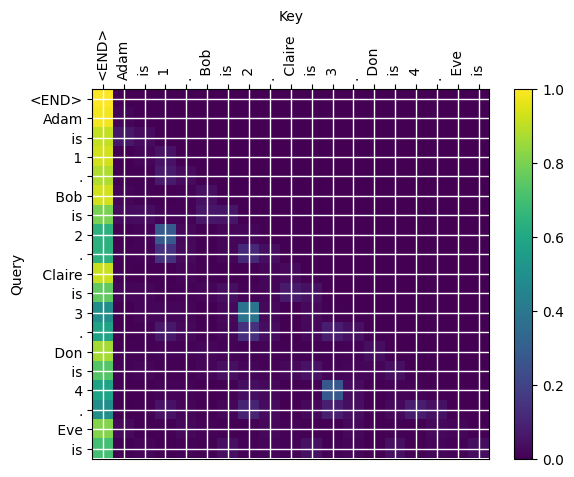

In [ ]:
import matplotlib.pyplot as plt

def visualize_attention_patterns(
    layer, head_index
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]

    # Convert tensor to numpy for visualization
    patterns_np = patterns.cpu().numpy()

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)

    # Rename the first token string as '<END>'
    str_tokens[0] = '<END>'

    # Create a new figure
    # plt.figure(figsize=(6, 6))
    plt.figure()

    # Create a heatmap
    plt.imshow(patterns_np, cmap='viridis', aspect='auto')

    # Set x and y axis labels
    plt.xticks(ticks=range(len(str_tokens)), labels=str_tokens, rotation=90)
    plt.yticks(ticks=range(len(str_tokens)), labels=str_tokens)

    plt.xlabel('Key')
    plt.ylabel('Query')
    # plt.title('Attention Patterns', pad=20)

    # Move x-axis ticks to the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # Add colorbar to show the color scale
    plt.colorbar()

    # Add grid lines to separate cells
    plt.grid(which='both', color='white', linewidth=1)

    # Display the plot
    plt.show()

visualize_attention_patterns(layer = 4, head_index = 4)

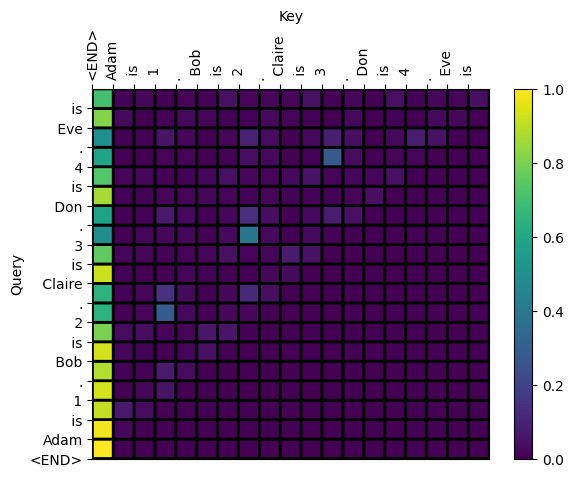

In [ ]:
import matplotlib.pyplot as plt

def visualize_attention_patterns(
    layer, head_index
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]

    # Convert tensor to numpy for visualization
    patterns_np = patterns.cpu().numpy()

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)

    # Rename the first token string as '<END>'
    str_tokens[0] = '<END>'

    # Create a new figure
    # plt.figure(figsize=(6, 6))
    plt.figure()

    # Create a heatmap
    # plt.imshow(patterns_np, cmap='viridis', aspect='auto')
    plt.pcolor(patterns_np, cmap='viridis', edgecolors='k', linewidths=2)

    # Set x and y axis labels
    plt.xticks(ticks=range(len(str_tokens)), labels=str_tokens, rotation=90)
    plt.yticks(ticks=range(len(str_tokens)), labels=str_tokens)

    plt.xlabel('Key')
    plt.ylabel('Query')
    # plt.title('Attention Patterns', pad=20)

    # Move x-axis ticks to the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # Add colorbar to show the color scale
    plt.colorbar()

    # Add grid lines to separate cells
    # plt.grid(which='both', color='white', linewidth=1)

    # Display the plot
    plt.show()

visualize_attention_patterns(layer = 4, head_index = 4)

Lighter is higher value

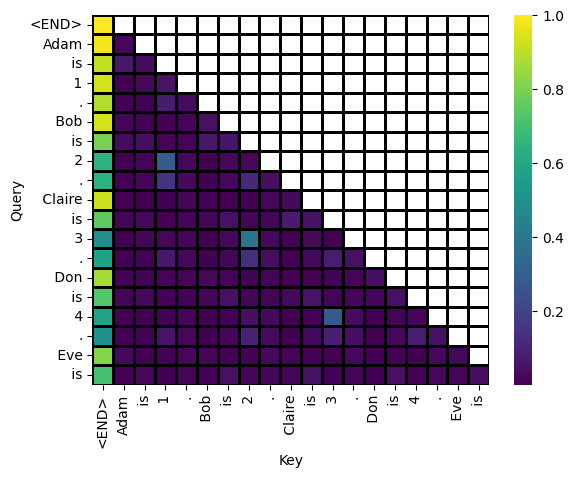

In [ ]:
import seaborn as sns

def visualize_attention_patterns(
    layer, head_index
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]

    # Convert tensor to numpy for visualization
    patterns_np = patterns.cpu().numpy()

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)

    # Rename the first token string as '<END>'
    str_tokens[0] = '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    # sns.heatmap(patterns_np, xticklabels=str_tokens, yticklabels=str_tokens, cmap='viridis', annot=False, fmt='.2f')
    sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        cmap='viridis',
        annot=False,
        fmt='.2f',
        linewidths=1,  # Set linewidth to create grid lines between cells
        linecolor='black',  # Set line color to black
        mask=mask
    )
    # Label x and y axes
    plt.xlabel('Key')
    plt.ylabel('Query')

visualize_attention_patterns(layer = 4, head_index = 4)

In [ ]:
# model.to_str_tokens(local_tokens)

In [ ]:
# Assuming your tokenized sentence is stored in a list called token_list
# and the tokens you are interested in are stored in variables token1 and token2
# token_list = ["Adam", "is", "1", ".", "Bob", "is", "2", ".", "Claire", "is", "3", ".", "Don", "is", "4", ".", "Eve", "is"]
token_list = model.to_str_tokens(local_tokens)
token1 = " 3"
token2 = " 2"

def get_attn_val(token_list, token1, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        batch_index = 0
        patterns = local_cache["attn", layer][batch_index, head_index]
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The heatmap value at "{token1}" "{token2}" is {heatmap_value}')
get_attn_val(token_list, token1, token2, 4, 4)

The heatmap value at " 3" " 2" is 0.3865317702293396


In [ ]:
get_attn_val(token_list, " 4", " 3", 4, 4)

The heatmap value at " 4" " 3" is 0.2757306694984436


In [ ]:
print(get_attn_val(token_list, " 3", " 2", 9, 1))
get_attn_val(token_list, " 4", " 3", 9, 1)

The heatmap value at " 3" " 2" is 0.02216947451233864
None
The heatmap value at " 4" " 3" is 0.045875243842601776


In [ ]:
def get_attn_val_fromEnd(token_list, token1, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = -1
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        batch_index = 0
        patterns = local_cache["attn", layer][batch_index, head_index]
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The heatmap value at last token to "{token2}" is {heatmap_value}')

In [ ]:
print(get_attn_val_fromEnd(token_list, " 3", " 2", 9, 1))
get_attn_val_fromEnd(token_list, " 4", " 3", 9, 1)
get_attn_val_fromEnd(token_list, " 4", " 4", 9, 1)

The heatmap value at last token to " 2" is 0.011337315663695335
None
The heatmap value at last token to " 3" is 0.07153023034334183
The heatmap value at last token to " 4" is 0.6279292106628418


In [ ]:
token_list = model.to_str_tokens(local_tokens)
token1 = " 3"
token2 = " 2"

def get_ind(token_list, token1, token2):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        print(f"The index of '{token1}' is {query_ind}")
        print(f"The index of '{token2}' is {key_ind}")

get_ind(token_list, " 3", " 2")

The index of ' 3' is 11
The index of ' 2' is 7


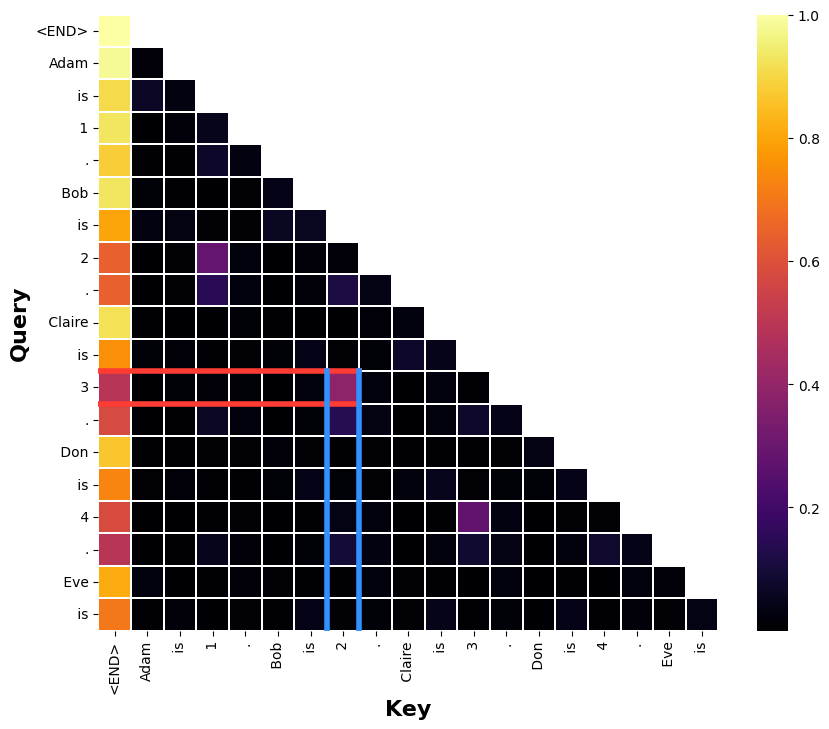

In [ ]:
import seaborn as sns
import matplotlib.patches as patches

def visualize_attention_patterns(
    layer, head_index,
    highlightLines = True
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]

    # Convert tensor to numpy for visualization
    patterns_np = patterns.cpu().numpy()

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)

    # Rename the first token string as '<END>'
    str_tokens[0] = '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        # cmap='viridis',
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',  # Set line color to white
        # cbar_kws={'label': 'Attention Weight'}
        mask=mask
    )

    # Move x-axis ticks to the top
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position('top')

    # Label x and y axes
    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    # Get the current limits of the plot
    xlim = plt.xlim()
    ylim = plt.ylim()

    if highlightLines:
        # for i in range(0, 19):
        #     rect = patches.Rectangle((i, i+1), 1, 1, linewidth=3, edgecolor='green', facecolor='none')
        #     ax.add_patch(rect)

        # for i in range(0, 8):  # For each column; on one row
        #     rect = patches.Rectangle((i, 11), 1, 1, linewidth=3, edgecolor='blue', facecolor='none')
        #     ax.add_patch(rect)
        # for i in range(12, len(str_tokens)): # For each row; on one col
        #     rect = patches.Rectangle((7, i), 1, 1, linewidth=3, edgecolor='blue', facecolor='none')
        #     ax.add_patch(rect)

        # line from (x1, y1) to (x2, y2): [x1, x2], [y1, y2]
        plt.plot([0, 8], [11, 11], color='#FF3C33', linewidth=4)  # top of highL row #pink- FF33D4
        plt.plot([0, 8], [12, 12], color='#FF3C33', linewidth=4)  # bot of highL row
        plt.plot([7, 7], [11, len(str_tokens)], color='#3390FF', linewidth=4)  # left of highL col
        plt.plot([8, 8], [11, len(str_tokens)], color='#3390FF', linewidth=4)  # right of highL col

        # for i in range(0, 8):
        #     plt.plot([8, 0], [0.5, 3.5], color='red', linewidth=2)
        # for i in range(12, len(str_tokens)):
        #     plt.plot([0.5, 3.5], [i, i], color='red', linewidth=2)

    # Restore the original limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Show the plot
    plt.show()

visualize_attention_patterns(layer = 4, head_index = 4)

In [ ]:
def visualize_attention_patterns(
    layer, head_index
):
    batch_index = 0
    patterns = local_cache["attn", layer][batch_index, head_index]

    # Convert tensor to numpy for visualization
    patterns_np = patterns.cpu().numpy()

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)

    # Rename the first token string as '<END>'
    str_tokens[0] = '<END>'

    imshow(patterns_np, labels={"x":"Key", "y":"Query"}, title="QK")

visualize_attention_patterns(layer = 4, head_index = 4)

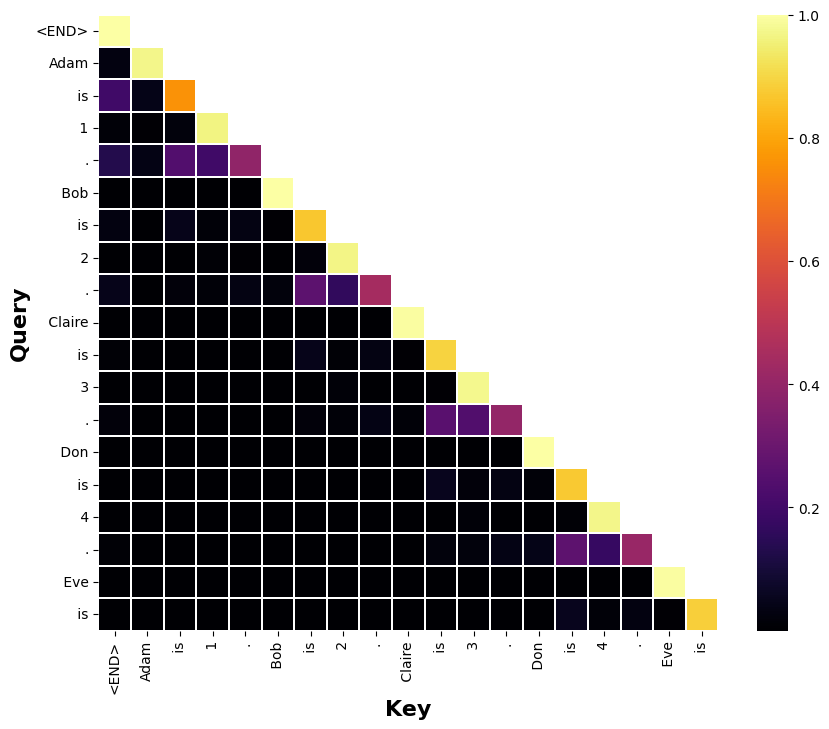

In [ ]:
visualize_attention_patterns(layer = 0, head_index = 3, highlightLines=False)

Induction pattern is new [A2] (query) attends to prev [B1] (key)

Here, [A2] (query) is new '.', and [B1] (key) is prev name, which is 3 tokens back

[A2] (query) is new number, and [B1] (key) is prev name, which is 2 tokens back

"Clare is 3. Don is 4."


[A1][B1][C][D] = Clare is 3.

new [C2] = [4], new [A2] = Don

so [4] attends to [Don] means [C2] attends to [A2]

This is prev token, not induction.

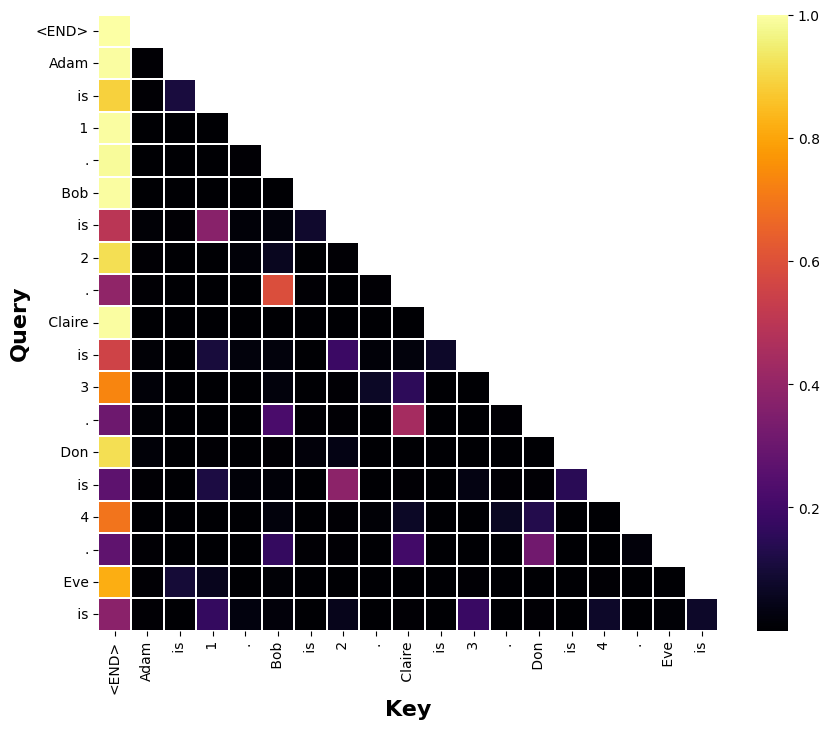

In [ ]:
visualize_attention_patterns(layer = 5, head_index = 5, highlightLines=False)

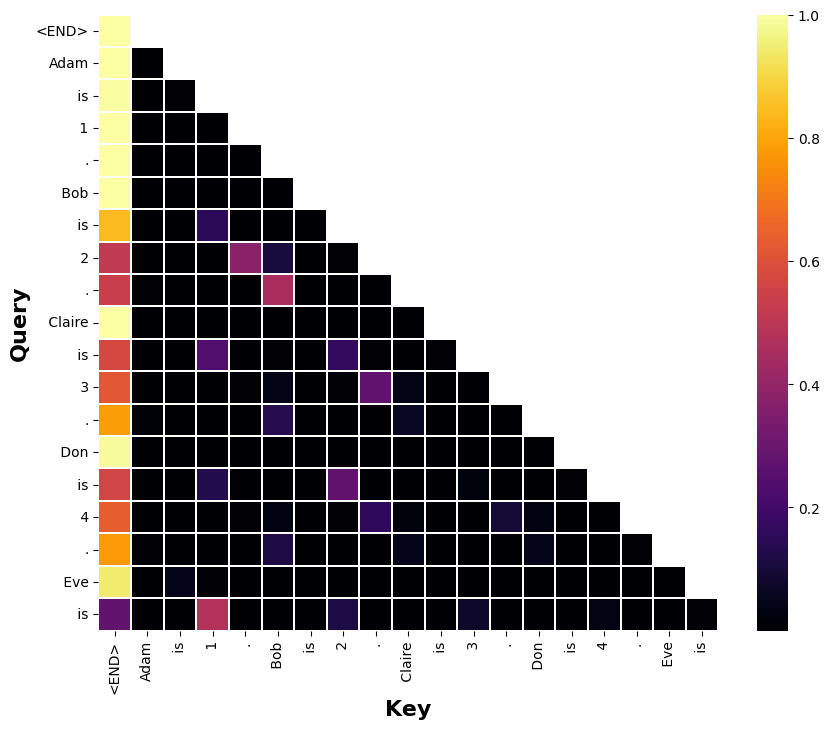

In [ ]:
visualize_attention_patterns(layer = 6, head_index = 9, highlightLines=False)

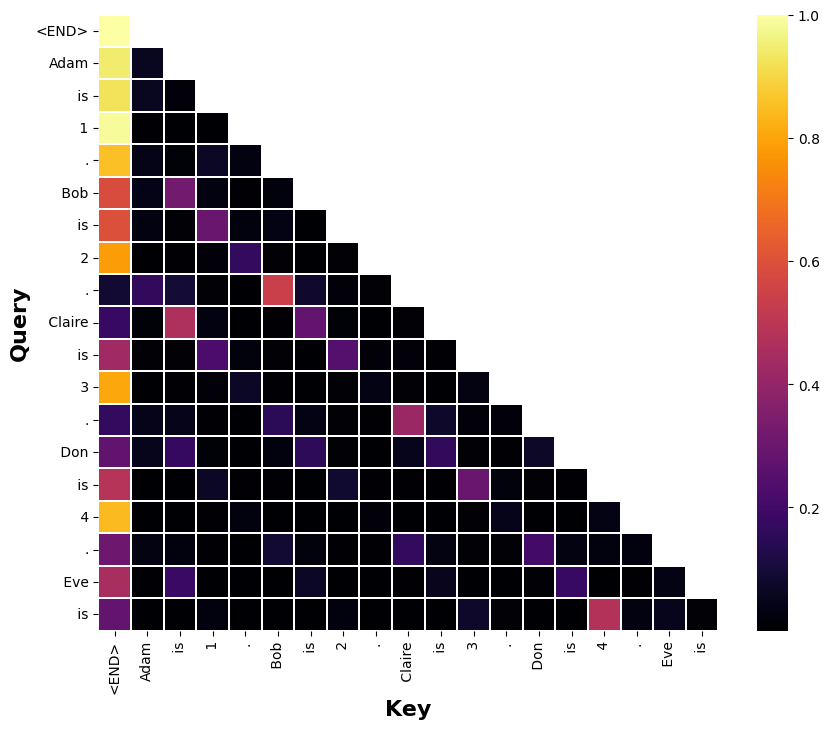

In [ ]:
visualize_attention_patterns(layer = 6, head_index = 1, highlightLines=False)

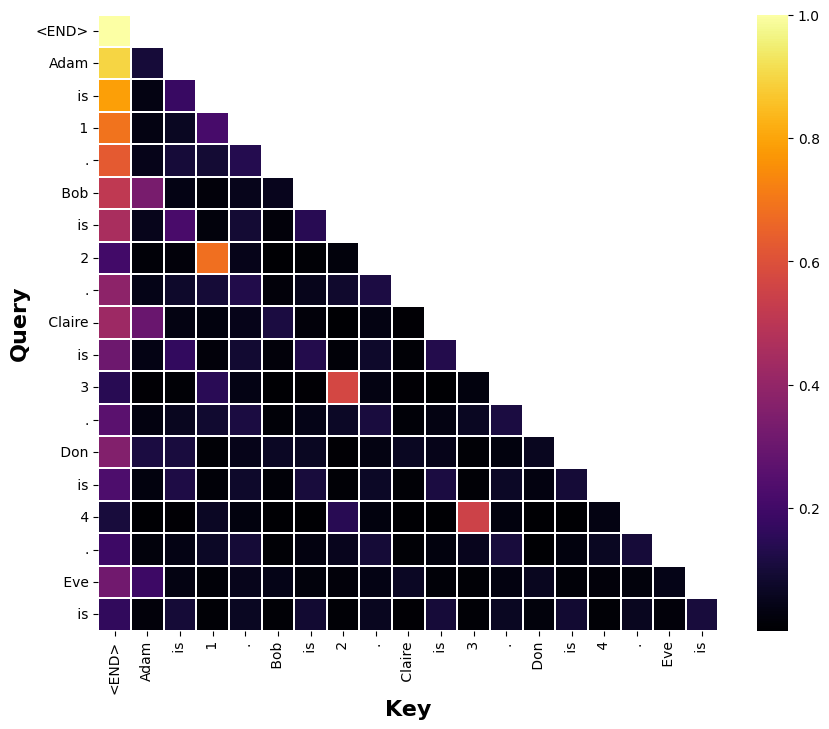

In [ ]:
visualize_attention_patterns(layer = 1, head_index = 5, highlightLines=False)

Warmer "sunnier" colors mean higher values.

# Activation Patching: Evidence for Information Movement

In [ ]:
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
corrupted_average_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print("Corrupted Average Logit Diff", corrupted_average_logit_diff)
print("Clean Average Logit Diff", original_average_logit_diff)

## Residual Stream

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff)/(original_average_logit_diff - corrupted_average_logit_diff)

patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, tokens.shape[1], device="cuda", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("resid_pre", layer),
                hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(patched_logit_diff)

In [ ]:
prompt_position_labels = [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokens[0]))]
imshow(patched_residual_stream_diff, x=prompt_position_labels, title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})

**How to interpret**

Look at which tokens on x-axis the colors initially start from (from top of y-axis down). This is relevant computation, as restoring its activation outputs restores the correct answer.

Which layers materr on which tokens?
- L on tokens:
    - T

Then observe which layers this computation occurs at another token. This indicates that at these layers, information is moved to this token.

Jumps suggest evidence for information movement:
- From L on T() to L on T()

---
<details><summary> Other notes </summary>

(In an abuse of notation, note that the difference here is averaged over *all* 8 prompts, while the labels only come from the *first* prompt.)

To be easier to interpret, we normalise the logit difference, by subtracting the corrupted logit difference, and dividing by the total improvement from clean to corrupted to normalise
0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
</details>

## Layers

In [ ]:
patched_attn_diff = torch.zeros(model.cfg.n_layers, tokens.shape[1], device="cuda", dtype=torch.float32)
patched_mlp_diff = torch.zeros(model.cfg.n_layers, tokens.shape[1], device="cuda", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("attn_out", layer),
                hook_fn)],
            return_type="logits"
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(patched_attn_logits, answer_tokens)
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("mlp_out", layer),
                hook_fn)],
            return_type="logits"
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(patched_mlp_logits, answer_tokens)

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(patched_attn_logit_diff)
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(patched_mlp_logit_diff)

In [ ]:
imshow(patched_attn_diff, x=prompt_position_labels, title="Logit Difference From Patched Attention Layer", labels={"x":"Position", "y":"Layer"})

**How to interpret**

Which (attn heads) layers matter on which tokens?
- LH _ on tokens:
    - T

---

If negative (red) right after blue, those layers likely only matter for direct logit effects

Deep blue right after the "jump": layers have heads that move info about (prev jump) token to (curr pos they're on) token.

In [ ]:
imshow(patched_mlp_diff, x=prompt_position_labels, title="Logit Difference From Patched MLP Layer", labels={"x":"Position", "y":"Layer"})

**How to interpret**

Which MLP layers matter on which tokens?
- LM _ on
    - T

Gray layers do not matter much.

---
**How it works**

<details><summary>MLP 0 </summary>
MLP 0 is usually blue for all cases on GPT-2 Small, so disregard it (perhaps b/c it's an extension of the embedding so when later layers want to access the input tokens they mostly read in the output of the first MLP layer, rather than the token embeddings. Within this frame, the first attention layer doesn't do much either)

The token(s) that MLP0 matters on are token positions that later layers want access to.
</details>

## Heads

**How it works**

Before, we found jumps across layers. Now, we identify which heads in those mid-layers are responsible for this.

To go from three dimensions (head_index, position and layer) to two, patch in a head's output across all positions.

The easiest way to do this is to patch in the activation `z`, the "mixed value" (QKV) of the attention head. That is, the average of all previous values weighted by the attention pattern, ie the activation that has yet to be multiplied by `W_O`, the output weights.

NOTE: though we are interested in info from token pos X to pos Y, these are for all positions

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][:, :, head_index, :]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("z", layer, "attn"),
                hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(patched_logit_diff)

In [ ]:
imshow(patched_head_z_diff, title="Logit Difference From Patched Head Output", labels={"x":"Head", "y":"Layer"})

**How to interpret**

Strong pos heads:
- L H

Strong neg heads:
- L H

Weak pos heads:
- L H

Weak neg heads:
- L H


See which ones above also are induction heads using
https://www.neelnanda.io/mosaic :
- L H

weak induction:
- L H

---
Then hypothesize how they interact:

Eg) Early heads: reinforce findings about how these detect X-type (eg. duplicated) tokens, which are then moved by mid-later heads. To determine this:
- In addition to the X-type heads identified before (from direct logit attribution), look at blue heads in mid-late "jump" layers


### Print top heads

In [ ]:
top_indices = get_top_indices(patched_head_z_diff, 10)

In [ ]:
top_indices  # copy this into "headFNs_expms_template.ipynb" (Section: Get important heads)

## Decomposing Heads

**How it works**

We can disentangle if QK (*where* to move information) or OV (*what* to move) is more important by patching in just the attention pattern *or* the value vectors. (https://www.youtube.com/watch?v=KV5gbOmHbjU) for more on this decomposition.

First let's patch in the value vectors, to measure when figuring out what to move is important. This has the same shape as z ([batch, pos, head_index, d_head]) so we can reuse the same hook.

In [ ]:
patched_head_v_diff = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("v", layer, "attn"),
                hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(patched_logit_diff)

In [ ]:
imshow(patched_head_v_diff, title="Logit Difference From Patched Head Value", labels={"x":"Head", "y":"Layer"})

In [ ]:
head_labels = [f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name = head_labels,
    color=einops.repeat(np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching")

**How to interpret**

Scatter plot against patching head outputs: heads that are not in vertical line matter more.

Patching in value vectors indicates these heads...

In [ ]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][:, head_index, :, :]
    return corrupted_head_pattern

patched_head_attn_diff = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=torch.float32)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("attn", layer, "attn"),
                hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(patched_logit_diff)


In [ ]:
imshow(patched_head_attn_diff, title="Logit Difference From Patched Head Pattern", labels={"x":"Head", "y":"Layer"})
head_labels = [f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name = head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching")

**How to interpret**

Patching in attention patterns indicates these heads...

# Consolidating Evidence for Head Functions into a Circuit

**How it works**

This takes how heads move info (QK, jumps), and what info they move (OV) and combines them with hypotheses about the task algorithms to determine possible, likely circuit layouts.

This doesn't use info about MLPs, so that can be incorporated later into a detailed hypothesized circuit.

## Visualizing Attention Patterns

In [ ]:
top_k = 10
top_heads_by_output_patch = torch.topk(patched_head_z_diff.abs().flatten(), k=top_k).indices
first_mid_layer = 7
first_late_layer = 9
early_heads = top_heads_by_output_patch[top_heads_by_output_patch<model.cfg.n_heads * first_mid_layer]
mid_heads = top_heads_by_output_patch[torch.logical_and(model.cfg.n_heads * first_mid_layer<=top_heads_by_output_patch, top_heads_by_output_patch<model.cfg.n_heads * first_late_layer)]
late_heads = top_heads_by_output_patch[model.cfg.n_heads * first_late_layer<=top_heads_by_output_patch]
visualize_attention_patterns(early_heads, title=f"Top Early Heads")
visualize_attention_patterns(mid_heads, title=f"Top Middle Heads")
visualize_attention_patterns(late_heads, title=f"Top Late Heads")

NameError: ignored

**How to interpret**

Categorize heads using:
1. layer location
2. from and to which tok type
3. behavior determined by V or QK?

Eg) early heads from second subject (to prev subjs / words next to them) det by V means: detect second subj is repeated token, and *which* is (eg. John)
    - Guess these are 'duplicate detection' heads

Eg) middle heads from final to 2nd subj token det by QK means: compose with early head outputs copy the information about the duplicate token to final token to *inhibit* the attention paid from late (name mover) heads to the first copy of the duplicated token

Eg) late heads from final to prev subj tokens det by QK means: compose with middle head outputs, and then attend to the correct IO name and copy that directly to the logits, using the S-Inhibition heads to inhibit attention to the first copy of the subject token.


## Visualizing Attention Patterns - from work backw circ

https://colab.research.google.com/drive/1onREXMNmc9ks0xpwDslUX2pdG0RSYtWS#scrollTo=d5B8DLeNfFOT&line=2&uniqifier=1

In [ ]:
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]


In [ ]:
top_heads_by_output_patch = torch.topk(patched_head_z_diff.abs().flatten(), k=top_k).indices
top_heads_by_output_patch

In [ ]:
top_k = 10
top_heads_by_output_patch = torch.topk(patched_head_z_diff.abs().flatten(), k=top_k).indices
first_mid_layer = 7
first_late_layer = 9
early_heads = top_heads_by_output_patch[top_heads_by_output_patch<model.cfg.n_heads * first_mid_layer]
mid_heads = top_heads_by_output_patch[torch.logical_and(model.cfg.n_heads * first_mid_layer<=top_heads_by_output_patch, top_heads_by_output_patch<model.cfg.n_heads * first_late_layer)]
late_heads = top_heads_by_output_patch[model.cfg.n_heads * first_late_layer<=top_heads_by_output_patch]
visualize_attention_patterns(early_heads, title=f"Top Early Heads")
visualize_attention_patterns(mid_heads, title=f"Top Middle Heads")
visualize_attention_patterns(late_heads, title=f"Top Late Heads")

**How to interpret**

Categorize heads using:
1. layer location
2. from and to which tok type
3. behavior determined by V or QK?

Eg) early heads from second subject (to prev subjs / words next to them) det by V means: detect second subj is repeated token, and *which* is (eg. John)
    - Guess these are 'duplicate detection' heads

Eg) middle heads from final to 2nd subj token det by QK means: compose with early head outputs copy the information about the duplicate token to final token to *inhibit* the attention paid from late (name mover) heads to the first copy of the duplicated token

Eg) late heads from final to prev subj tokens det by QK means: compose with middle head outputs, and then attend to the correct IO name and copy that directly to the logits, using the S-Inhibition heads to inhibit attention to the first copy of the subject token.


## Auto guess head type and connections

top attention heads tokens attend to what? measure "semantically similar" type by dot product cosine, and get value. Then input this into "circuit type" and run through mimimal model ablation.

To do:
Output the tokens for each head

## Create a Circuit Diagram

Use Visio, etc. to make a hypothesized circuit based on:  
1. How heads move info to layers (via jumps, attn pat)
2. What info is moved (attn pat, OV)
    - Eg) duplicate heads should:
        - 1. Attend from 2nd subj to 1st subj
        - 2. outputs are then moved to the last token by V-Composition with another head
3. Guesses how heads work with each other, seeing if this aligns with hypotheses about possible algorithms
    - Eg) if early heads are 'duplicates', what (mid/late) heads move their output info? What heads alter this info? This coincides with hypothesis that attn heads move and inhibit tokens

![](https://pbs.twimg.com/media/FghGkTAWAAAmkhm.jpg)

**Summary Example**


* Early: The duplicate token heads, previous token heads and induction heads. These serve the purpose of detecting that the second subject is duplicated and which earlier name is the duplicate.
    * We found a direct duplicate token head which behaves exactly as expected, L3H0. Heads L5H0 and L6H9 are induction heads, which explains why they don't attend directly to the earlier copy of John!
    * Note that the duplicate token heads and induction heads do not compose with each other - both directly add to the S-Inhibition heads. The diagram is somewhat misleading.
* Middle: They call these S-Inhibition heads - they copy the information about the duplicate token from the second subject to the to token, and their output is used to *inhibit* the attention paid from the name movers to the first subject copy. We found all these heads, and had a decent guess for what they did.
    * In either case they attend to the second subject, so the patch that mattered was their value vectors!
* Late: They call these name movers, and we found some of them. They attend from the final token to the indirect object name and copy that to the logits, using the S-Inhibition heads to inhibit attention to the first copy of the subject token.
    * We did find their surprising result of *negative* name movers - name movers that inhibit the correct answer!
    * They have an entire category of heads we missed called backup name movers - we'll get to these later.

# More Questions About Head Functions

Aside from the main heads involved in our hypothesized algorithm, we may notice other heads involved. Analyze them after constructing a possible "main" circuit. Examples include:

## Why these Early Heads are Induction Heads?

**How it works**

Some of the early heads detecting duplicated tokens are induction heads, not just direct duplicate token heads.

An induction head can detect and continue repeated sequences. It is the second head in a two head induction circuit, which looks for previous copies of the current token (A) and attends to the token *after* it (B), and then copies that (B) to the current position and predicts that it will come next. [See paper](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html).

![](https://pbs.twimg.com/media/FNWAzXjVEAEOGRe.jpg)

This is surprising because it feels like overkill. The model doesn't care about *what* token comes after the first copy of the subject, just that it's duplicated. And it already has simpler duplicate token heads.

Best guess: model just already had induction heads around and that, in addition to their main function, they *also* only activate on duplicated tokens. So it was useful to repurpose this existing machinery.

This suggests that in larger models, components in simpler circuits (possibly existed in smaller models) get repurposed and built upon into more complicated circuits.

We can verify that these are induction heads by running the model on repeated text and plotting the heads.

---

<details> <summary>Caveats</summary>

Note that this is a superficial study of whether something is an induction head - we totally ignore the question of whether it actually does boost the correct token or whether it composes with a single previous head and how. In particular, we sometimes get anti-induction heads which suppress the induction-y token (no clue why!), and this technique will find those too . But given the previous rigorous analysis, we can be pretty confident that this picks up on some true signal about induction heads.
</details>

<details> <summary>Technical Implementation Details</summary>

We can do this again by using hooks, this time just to access the attention patterns rather than to intervene on them.

Our hook function acts on the attention pattern activation. This has the name "blocks.{layer}.{layer_type}.hook_{activation_name}" in general, here it's "blocks.{layer}.attn.hook_attn". And it has shape [batch, head_index, query_pos, token_pos]. Our hook function takes in the attention pattern activation, calculates the score for the relevant type of head, and write it to an external cache.

We add in hooks using `model.run_with_hooks(tokens, fwd_hooks=[(names_filter, hook_fn)])` to temporarily add in the hooks and run the model, getting the resulting output. Previously names_filter was the name of the activation, but here it's a boolean function mapping activation names to whether we want to hook them or not. Here it's just whether the name ends with hook_attn. hook_fn must take in the two inputs activation (the activation tensor) and hook (the HookPoint object, which contains the name of the activation and some metadata such as the current layer).

Internally our hooks use the function `tensor.diagonal`, this takes the diagonal between two dimensions, and allows an arbitrary offset - offset by 1 to get previous tokens, seq_len to get duplicate tokens (the distance to earlier copies) and seq_len-1 to get induction heads (the distance to the token *after* earlier copies). Different offsets give a different length of output tensor, and we can now just average to get a score in [0, 1] for each head
</details>

In [ ]:
example_text = "Research in mechanistic interpretability seeks to explain behaviors of machine learning models in terms of their internal components."
example_repeated_text = example_text + example_text
example_repeated_tokens = model.to_tokens(example_repeated_text, prepend_bos=True)
example_repeated_logits, example_repeated_cache = model.run_with_cache(example_repeated_tokens)
induction_head_labels = [81, 65]
visualize_attention_patterns(induction_head_labels, example_repeated_cache, example_repeated_tokens, title="Induction Heads")

**How to interpret**

Eg) 'explain behaviors' -> 'explain'

Explain (src, A) attends to 'behaviors (tgt, B) so that it will output 'behaviors' next

More examples: 'machine learning', 'learning models'

(Every token pair, which overlaps with the next pair, in this phrase, as it's repeated multiple times, is detected as an induction pattern by these heads)

Measure:

- the average attention paid from the second copy of a token to the token AFTER the first copy.

- the average attention paid from the second copy of a token to the first copy of the token (which is the attention that the induction head would pay if it were a duplicate token head)

- the average attention paid to the previous token to find previous token heads

In [ ]:
seq_len = 100
batch_size = 2

prev_token_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device="cuda")
def prev_token_hook(pattern, hook):
    layer = hook.layer()
    diagonal = pattern.diagonal(offset=1, dim1=-1, dim2=-2)
    # print(diagonal)
    # print(pattern)
    prev_token_scores[layer] = einops.reduce(diagonal, "batch head_index diagonal -> head_index", "mean")
duplicate_token_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device="cuda")
def duplicate_token_hook(pattern, hook):
    layer = hook.layer()
    diagonal = pattern.diagonal(offset=seq_len, dim1=-1, dim2=-2)
    duplicate_token_scores[layer] = einops.reduce(diagonal, "batch head_index diagonal -> head_index", "mean")
induction_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device="cuda")
def induction_hook(pattern, hook):
    layer = hook.layer()
    diagonal = pattern.diagonal(offset=seq_len-1, dim1=-1, dim2=-2)
    induction_scores[layer] = einops.reduce(diagonal, "batch head_index diagonal -> head_index", "mean")
original_tokens = torch.randint(100, 20000, size=(batch_size, seq_len))
repeated_tokens = einops.repeat(original_tokens, "batch seq_len -> batch (2 seq_len)").cuda()

pattern_filter = lambda act_name: act_name.endswith("hook_attn")
loss = model.run_with_hooks(repeated_tokens, return_type="loss", fwd_hooks=[(pattern_filter, prev_token_hook), (pattern_filter, duplicate_token_hook), (pattern_filter, induction_hook)])
print(utils.get_corner(prev_token_scores))
print(utils.get_corner(duplicate_token_scores))
print(utils.get_corner(induction_scores))

**How to interpret**

Check if the relevant early heads are induction heads (and?)/or duplicate token heads by seeing which heatmap they belong to:

In [ ]:
imshow(prev_token_scores, labels={"x":"Head", "y":"Layer"}, title="Previous Token Scores")
imshow(duplicate_token_scores, labels={"x":"Head", "y":"Layer"}, title="Duplicate Token Scores")
imshow(induction_scores, labels={"x":"Head", "y":"Layer"}, title="Induction Head Scores")

## Backup Heads

**How it works**

If we knock out one of the X-type heads, then there are some backup heads in later layers that *change their behaviour* and do (some of) the job of the original head's job.


---


<details><summary>Ablation issues</summary>

If the model is robust to ablating a head to zero after running, then naively we can be confident that the head is not doing anything important. Issues include: that the average output of the head may be far from zero and so the knockout may send it far from expected activations, breaking internals on *any* task.
</details>


<details> <summary>Implementation Details</summary>

To ablate: use a custom ablation hook and then cache all new activations and compared performance

We can just define a hook on the z activation in the relevant attention layer (recall, z is the mixed values, and comes immediately before multiplying by the output weights $W_O$). z has a head_index axis, so we can set the component for the relevant head and for position -1 to zero, and return it. (Technically we could just edit in place without returning it, but by convention we always return an edited activation).

We now want to compare all internal activations with a hook, which is hard to do with the nice `run_with_hooks` API. So we can directly access the hook on the z activation with `model.blocks[layer].attn.hook_z` and call its `add_hook` method. This adds in the hook to the *global state* of the model. We can now use run_with_cache, and don't need to care about the global state, because run_with_cache internally adds a bunch of caching hooks, and then removes all hooks after the run, *including* the previously added ablation hook. This can be disabled with the reset_hooks_end flag, but here it's useful!
</details>


**How to interpret**

Ablate the most important X-type head on just the final token (final position to ablate the direct logit effect)

Does removing the top X-type reduce the logit diff a lot? If it only goes down a little, that suggests there are backup X-type heads.


In [ ]:
top_name_mover = per_head_logit_diffs.flatten().argmax().item()
top_name_mover_layer = top_name_mover//model.cfg.n_heads
top_name_mover_head = top_name_mover % model.cfg.n_heads
print(f"Top Name Mover to ablate: L{top_name_mover_layer}H{top_name_mover_head}")
def ablate_top_head_hook(z: Float[torch.Tensor, "batch pos head_index d_head"], hook):
    z[:, -1, top_name_mover_head, :] = 0
    return z
# Adds a hook into global model state
model.blocks[top_name_mover_layer].attn.hook_z.add_hook(ablate_top_head_hook)
# Runs the model, temporarily adds caching hooks and then removes *all* hooks after running, including the ablation hook.
ablated_logits, ablated_cache = model.run_with_cache(tokens)
print(f"Original logit diff: {original_average_logit_diff}")
print(f"Post ablation logit diff: {logits_to_ave_logit_diff(ablated_logits, answer_tokens).item()}")
print(f"Direct Logit Attribution of top name mover head: {per_head_logit_diffs.flatten()[top_name_mover].item()}")
print(f"Naive prediction of post ablation logit diff: {original_average_logit_diff - per_head_logit_diffs.flatten()[top_name_mover].item()}")

**How it works**

Look at the direct logit attribution of each head to see what's going on. It's easiest to interpret if plotted as a scatter plot against the initial per head logit difference.

In [ ]:
per_head_ablated_residual, labels = ablated_cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_ablated_logit_diffs = residual_stack_to_logit_diff(per_head_ablated_residual, ablated_cache)
per_head_ablated_logit_diffs = per_head_ablated_logit_diffs.reshape(model.cfg.n_layers, model.cfg.n_heads)
imshow(per_head_ablated_logit_diffs, labels={"x":"Head", "y":"Layer"})
scatter(y=per_head_logit_diffs.flatten(), x=per_head_ablated_logit_diffs.flatten(), hover_name=head_labels, range_x=(-3, 3), range_y=(-3, 3), xaxis="Ablated", yaxis="Original", title="Original vs Post-Ablation Direct Logit Attribution of Heads")

**How to interpret**

Points that stay on the x=y diagonal don't change, but those that deviate from it change a lot once ablate.

(Hover to see head names and exact x and y values)

Eg) negative name mover L10H7 decreases its negative effect a lot, adding +1 to the logit diff (ablated - original ~ 1)

Eg) backup name mover L10H10 adjusts its effect to be more positive, adding +0.8 to the logit diff

The ablated head should be down to zero

### Why do Backup Heads change their behavior upon ablation?

One natural hypothesis is that this is because the final LayerNorm scaling has changed, which can scale up or down the final residual stream. This is slightly true, and we can see that the typical head is a bit off from the x=y line. But the average LN scaling ratio is 1.04, and this should uniformly change *all* heads by the same factor, so this can't be sufficient

In [ ]:
print("Average LN scaling ratio:", (cache["ln_final.hook_scale"][:, -1]/ablated_cache["ln_final.hook_scale"][:, -1]).mean().item())
print("Ablation LN scale", ablated_cache["ln_final.hook_scale"][:, -1])
print("Original LN scale", cache["ln_final.hook_scale"][:, -1])

**Exercise to the reader:** Can you finish off this analysis? What's going on here? Why are the backup name movers changing their behaviour? Why is one negative name mover becoming significantly less important?